In [1]:
## PACKAGES


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import sys
sys.path.insert(1,'/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/examples/Scripts')
from pyDeepInsightv3 import ImageTransformer, CAMFeatureSelector

/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/uma

In [2]:
##LOAD DATA
expr_file = r"../data/Survival_TCGA_VS_Desmd/filtered_desmd_average_ver1.csv"
expr1 = pd.read_csv(expr_file, encoding='utf-8', engine='python')
expr=expr1.transpose()
expr.columns=expr.iloc[0]
X_all = expr.iloc[1:,1:-1].values
X_all=X_all.astype(float)
days= expr.iloc[1:,-1].values
genes = expr.iloc[:,:-1].columns.to_numpy()


In [3]:
# expr_file = r"../data/Survival_TCGA_VS_Desmd/filtered_desmd_average_ver1.csv"
# expr1 = pd.read_csv(expr_file, encoding='utf-8', engine='python')
# abc=expr1.transpose()
# abc.columns=abc.iloc[0]
# abc=abc.iloc[1:,0:]



In [4]:
# for i in range(169,198,1):
#     if int(abc.iloc[i,12587])>=3000:
#         print(abc.index[i])

In [5]:
X=np.zeros((160,12586))
Y=[]
check=[]
j=0
for i in range(198):
    if days[i]<=1500:
        X[j]=X[j]+X_all[i]
        Y.append('short')
        check.append(days[i])
        j=j+1
    if days[i]>=3000:
        X[j]=X[j]+X_all[i]
        Y.append('long')
        check.append(days[i])
        j=j+1
    

In [6]:
X

array([[ 0.24870121,  0.83692314,  0.0789976 , ..., -0.54504941,
         0.17702886,  0.32101749],
       [ 0.83055052,  0.5656943 , -0.19102257, ...,  0.5442731 ,
         0.0125721 , -0.57008071],
       [ 0.16131057, -0.36416   ,  0.35390092, ..., -0.36894645,
         0.08628174,  0.21923908],
       ...,
       [ 1.69953223, -0.04507484,  0.03602488, ..., -0.03583663,
         0.61470121, -0.68256057],
       [ 1.16834547, -0.17101104, -1.25094651, ..., -1.03554487,
         0.2826298 ,  0.01224415],
       [ 0.59644604, -0.05816743,  0.37558155, ...,  0.20805214,
         0.80238499, -0.25519468]])

Remove low variance data. In this case the bottom 30%.

In [7]:
var_filter = X.var(0) >= np.percentile(X.var(0), 10., method='nearest')

In [8]:
mms = MinMaxScaler()
X_norm = mms.fit_transform(X)
#X_test_norm = mms.transform(X_test)


Encode the classes

In [9]:
le = LabelEncoder()
y_enc = le.fit_transform(Y)
#y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size

In [10]:
num_classes

2

## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [11]:
reducer = umap.UMAP(
    #n_neighbors=40,
    n_components=2,
    min_dist=0.5,
    metric='cosine',
    n_jobs=-1,
    ##random_state=42
)

pixel_size = (32,32)

it = ImageTransformer(
    feature_extractor='kPCA',
    pixels=pixel_size)


printing result from KernelPCA(kernel='rbf', n_components=2) and the xyz is  [[ 0.19306179 -0.12642172]
 [ 0.05481375 -0.04143745]
 [-0.00876029 -0.01273004]
 ...
 [ 0.19405013  0.01707698]
 [-0.11684887 -0.0045588 ]
 [-0.05963169 -0.03171617]]
printing chvertices


/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/examples/Scripts/pyDeepInsightv3/image_transformer.py:277: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


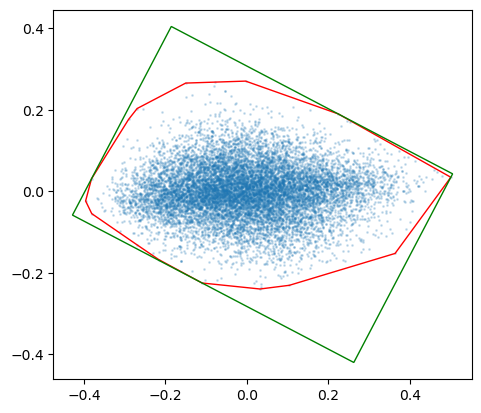

In [12]:
it.fit(X_norm, y=Y, plot=True)

In [13]:
X_img = it.transform(X_norm)
#X_test_img = it.transform(X_test_norm)

In [14]:
import torchvision.transforms as transforms
from PIL import Image

In [15]:
transforming_samples=X_img.astype(np.uint8)
#chosen_samples=chosen_samples2[~chosen_indices]

transforming_samples=[Image.fromarray(image) for image in transforming_samples]

data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformed_samples=[data_transforms(x) for x in transforming_samples]
transformed_samples=[np.array(x) for x in transforming_samples]
X_new_img=np.concatenate((X_img,transformed_samples))
Y_new=np.concatenate((Y,Y))
    #y_train_modified[i+1]="short"

In [16]:
random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
X_new_img, Y_new, test_size=0.2, shuffle=True, stratify=Y_new)

In [17]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

## U-net Based Classifiation:

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
class CNN(torch.nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.model = torch.nn.Sequential( 
            #Input = 3 x 256 x 256, Output = 224 x 224 x 224 
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),  
            #torch.nn.BatchNorm2d(224),
            torch.nn.ReLU(), 
            #Input = 256 x 256 x 256, Output = 256 x 128 x 128 
            torch.nn.MaxPool2d(kernel_size=2), 
           
            

            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), 
            #torch.nn.BatchNorm2d(224),
            torch.nn.ReLU(), 
            # # # #Input = 512 x 16 x 16 , Output = 512 x 8 x 8  
            # #torch.nn.MaxPool2d(kernel_size=4),
            # # # # torch.nn.ReLU(), 
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            # torch.nn.BatchNorm2d(448), 
            torch.nn.ReLU(), 
            torch.nn.MaxPool2d(kernel_size=2),

            # torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1), 
            # torch.nn.ReLU(), 
            # # # #Input = 512 x 16 x 16 , Output = 512 x 8 x 8  
            # #torch.nn.MaxPool2d(kernel_size=4),
            # # # # torch.nn.ReLU(), 
            # torch.nn.MaxPool2d(kernel_size=4,stride=2),
  
            torch.nn.Flatten(), 
            torch.nn.Linear(64*4*4, 1024), 
            #torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(), 
            torch.nn.Linear(1024, 2),

           
        ) 
        self.layers=[]
  
    def forward(self, x): 
        input_shape=x.shape
        self.layers=[(0,input_shape)]

        for i,layer in enumerate(self.model):
            x=layer(x)
            output_shape=x.shape
            self.layers.append((i+1,output_shape))
        
        return x

In [20]:
model = CNN().to(device)
input_tensor=torch.randn(1,3,32,32).to(device)
output_tensor, layers_info = model(input_tensor)
for i, ((input_shape, output_shape)) in enumerate(layers_info):
    print(f"Layer {i}: Input shape = {input_shape}, Output shape = {output_shape}")

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
#Selecting the appropriate training device 
model = CNN().to(device)

batch_size=5
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Example usage:
early_stopping = EarlyStopping(patience=10, verbose=True)


In [ ]:
torch.mean(trainset[0][0][0])

In [ ]:
#Defining the model hyper parameters 
num_epochs = 20
learning_rate = 0.0001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1) 

#Training process begins 
train_loss_list = [] 
for epoch in range(num_epochs): 
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
	train_loss = 0
	
	#Iterating over the training dataset in batches 
	model.train() 
	for i, (images, labels) in enumerate(trainloader): 
		
		#Extracting images and target labels for the batch being iterated 
		images = images.to(device) 
		labels = labels.to(device) 

		#Calculating the model output and the cross entropy loss 
		outputs = model(images) 
		loss = criterion(outputs, labels) 

		#Updating weights according to calculated loss 
		optimizer.zero_grad() 
		loss.backward() 
		optimizer.step() 
		train_loss += loss.item()
	train_loss /= len(trainloader.dataset)
	early_stopping(train_loss, model)
	#Printing loss for each epoch 
	train_loss_list.append(train_loss/len(trainloader)) 
	

	#print(f"Training loss = {train_loss_list[-1]}") 
	if early_stopping.early_stop:
		print("Early stopping")
		break
	


In [ ]:
test_acc=0
model.eval() 
output_res=[]
output_origin=[]
exam=np.zeros((33,3,2))
p=0
  
with torch.no_grad(): 
    #Iterating over the training dataset in batches 
    for i, (images, labels) in enumerate(testloader): 
          
        images = images.to(device) 
        y_true = labels.to(device) 
        output_origin.extend(y_true.cpu().numpy())
          
        #Calculating outputs for the batch being iterated 
        outputx= model(images) 
          
        #Calculated prediction labels from models 
        _, y_pred = torch.max(outputx.data, 1) 
        output_res.extend(y_pred.cpu().numpy())

        #for debugging
        #exam[p]=exam[p]+outputx.cpu().numpy()
        p=p+1
        print(outputx)
        #Comparing predicted and true labels 
        test_acc += (y_pred == y_true).sum().item() 
      
print(f"Test set accuracy = {100 * test_acc / len(X_test)} %")

In [ ]:
exam=np.zeros((1,3,2))
exam[0]=exam[0]+outputx.cpu().numpy()
exam[0]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classes=('long','short')
cf_matrix = confusion_matrix(output_origin, output_res)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [ ]:
model=model.to(torch.device('cpu'))
with torch.no_grad():
    y_hat = model(X_train_tensor.cpu())
train_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_enc):.3f}")

## CNN Image Classification
Train ResNet50 CNN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
net = timm.create_model('resnet50', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)
net.fc=torch.nn.Sequential(
               torch.nn.Linear(2048, 128),
               torch.nn.ReLU(inplace=True),
               torch.nn.Linear(128, 2)).to(device)
#nn.Linear(net.fc.in_features,2)

In [ ]:
batch_size=20
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor1 = torch.stack([preprocess(img) for img in X_train]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor1, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

X_test_tensor = torch.stack([preprocess(img) for img in X_test]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
trainloader

In [ ]:
criterion = nn.CrossEntropyLoss()
#ptimizer = optim.SGD(net.parameters(),lr=1e-02,momentum=2,)
optimizer = optim.Adam(net.parameters(),lr=0.0001)

In [ ]:
net.train()
net = net.to(device)
for epoch in range(10):
    for i, (inputs, labels) in enumerate(trainloader):
        clear_output(wait=True)
        display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
test_predicted = np.empty(0)
test_true = np.empty(0)
net=net.to(device)
net.eval()


with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())

net=net.to(torch.device('cpu'))
with torch.no_grad():
    y_hat = net(X_train_tensor1.cpu())
train_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_enc):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")


In [ ]:
classes=('long','short')
cf_matrix = confusion_matrix(test_true, test_predicted)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

## SqueezeNet

In [ ]:
import torchvision
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_sq = torchvision.models.squeezenet1_1(weights='DEFAULT')
model_sq.classifier.append(nn.Flatten())
_ = model_sq.classifier.append(nn.Linear(1000, num_classes))

##transforming image to tensor
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
X_train_tensor_sq = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor_sq = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor_sq = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor_sq = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [ ]:
batch_size = 10

trainset = TensorDataset(X_train_tensor_sq, y_train_tensor_sq)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor_sq, y_test_tensor_sq)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model_sq.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

## DeepFeature: CAM-based Feature Selection

In [ ]:
model_sq.train()
model_sq.to(device1)
for epoch in range(120):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device1)
        labels = labels.to(device1)

        outputs = model_sq(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')

In [ ]:
model_sq.to('cpu')
model_sq = model_sq.eval()

with torch.no_grad():
    y_hat = model_sq(X_train_tensor_sq)
train_predicted = torch.max(y_hat, 1)[1]


with torch.no_grad():
    y_hat = model_sq(X_test_tensor_sq)
test_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor_sq):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor_sq):.3f}")

In [ ]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

In [ ]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

In [ ]:
fs_threshold = 0.6
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

In [ ]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

In [ ]:
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")